In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms



In [16]:
root = "./"
BATCH_SIZE = 500
N_INP = 32
N_OUT = 784
N_GEN_EPOCHS = 10
KERNEL_TYPE = "multiscale"

In [4]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Class definition Generative with Maximum Mean Discrepancy (GMMD)
class GMMD(nn.Module):
    def __init__(self, n_start, n_out):
        super(GMMD, self).__init__()
        self.fc1 = nn.Linear(n_start, 1000)
        self.fc2 = nn.Linear(1000, 600)
        self.fc3 = nn.Linear(600, 1000)
        self.fc4 = nn.Linear(1000, n_out)

    def forward(self, samples):
        x = F.sigmoid(self.fc1(samples))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x

In [8]:
root = './data'  # or any writable directory

trans = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root=root, train=True, transform=trans, download=True)
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True
)


100.0%
100.0%
100.0%
100.0%


In [9]:
# define the GMMD

gmmd_net = GMMD(N_INP, N_OUT).to(device)

try:
  gmmd_net.load_state_dict(torch.load("gmmd.pth"))
  print("Model parameters are loaded")

except:
  pass

gmmd_optimizer = optim.RMSprop(gmmd_net.parameters(), lr=0.003)

In [13]:
def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)



    return torch.mean(XX + YY - 2. * XY)

In [14]:
def train_one_step(x, samples):
    samples = Variable(samples).to(device)
    gen_samples = gmmd_net(samples)

    loss = MMD(x, gen_samples, KERNEL_TYPE)
    gmmd_optimizer.zero_grad()
    loss.backward()
    gmmd_optimizer.step()

    return loss

In [17]:
# training loop
iterations = 0
Z = torch.randn((120,BATCH_SIZE, N_INP))
for ep in range(N_GEN_EPOCHS):
    avg_loss = 0
    resampling_limit = 300 # From paper

    for idx, (x, _) in enumerate(train_loader):
        iterations += 1
        x = x.view(x.size()[0], -1)
        x = Variable(x).to(device)

        # normal random noise between [0, 1]
        random_noise = Z[idx,:,:]

        loss = train_one_step(x, random_noise)
        avg_loss += loss.item()

        if iterations % 300 == 0:
           Z = random_noise = torch.randn((120,BATCH_SIZE, N_INP))


    avg_loss /= (idx + 1)
    print(f"GMMD Training: {ep}. epoch completed, average loss: {avg_loss}")

torch.save(gmmd_net.state_dict(), "gmmd.pth")


GMMD Training: 0. epoch completed, average loss: 0.07540859964986642
GMMD Training: 1. epoch completed, average loss: 0.050839640417446694
GMMD Training: 2. epoch completed, average loss: 0.034591064369305966
GMMD Training: 3. epoch completed, average loss: 0.028694134190057716
GMMD Training: 4. epoch completed, average loss: 0.02610247425424556
GMMD Training: 5. epoch completed, average loss: 0.024424334041153392
GMMD Training: 6. epoch completed, average loss: 0.023315404898797472
GMMD Training: 7. epoch completed, average loss: 0.022793438037236533
GMMD Training: 8. epoch completed, average loss: 0.022161195628965895
GMMD Training: 9. epoch completed, average loss: 0.02189233396202326


100.0%
100.0%
100.0%
100.0%


Images generated by GMMD


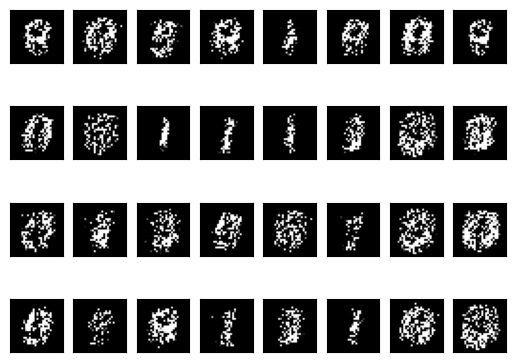

In [18]:
import matplotlib.pyplot as plt

Z = random_noise = torch.randn((120,BATCH_SIZE, N_INP))
trans = transforms.Compose([transforms.ToTensor()])
test_set = datasets.MNIST(root=root, train=False, transform=trans, download=True)
view_data = [test_set[i][0] for i in range(4 * 8)]
plt.gray()

print("Images generated by GMMD")

for r in range(4):
  for c in range(8):
    ax = plt.subplot(4, 8, r * 8 + c + 1)

    noise = torch.randn((1, N_INP)).to(device)
    y = gmmd_net(noise)
    plt.imshow(y.detach().squeeze().cpu().reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

